In [9]:
# imports of all the libaries i need
import re
import pandas as pd
import numpy as np
import random as rnd

# Algorithm
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassiefier seems to work the best


# The basic data exploration and visualization has been done in the jupyter notebook
# Therefore i will not repeat the steps in this


test_df = pd.read_csv("titanic/test.csv")
train_df = pd.read_csv("titanic/train.csv")


data = [train_df, test_df]
for dataset in data:
    # A new column is genereated with the name "relatives" it is the result of the addition of "SibSp" and "Parch"
    dataset["relatives"] = dataset["SibSp"] + dataset["Parch"]
    # loc generates the column if it is not existing at the beginning
    # With loc we iterate over every row and ask for a condition -> if the value in dataset["relatives"] > 0 we wil write 0
    # into the "not_alone" column. Or 1 if the value is equal 1.(This means the person IS ALONE)
    dataset.loc[dataset["relatives"] > 0, "not_alone"] = 0
    dataset.loc[dataset["relatives"] == 0, "not_alone"] = 1
    dataset["not_alone"] = dataset["not_alone"].astype(int)


# In the next step we will delete our "PassengerId" column because I dont think there is a correalation
# between the "PassengerId" and anything else.
train_df = train_df.drop(["PassengerId"], axis=1)


# ---------------------------------
# In the next Step we will try to convert the "Embarked" column into a numeric column
# because it seems that there is a correaltion because "Embarked" indicates on which floor the person
# has had his room. This probably seems to be interesting

# We will import the re libary for regex expressions
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]


for dataset in data:
    # In the first step we are filling the missing values with "U0" because we can see with the line:
    # missing_values = train_df.isnull().sum().sort_values(ascending=True) that in Embarked are 2 Values missing
    dataset["Cabin"] = dataset["Cabin"].fillna("U0")
    # We itereate over each row in "Cabin" with the map function
    # The compile function compiles a regular expression into a reuglar expression object
    # on the compiled regular expression we can use the search method ir returns the index of the match
    # group returns the match kinda...
    # for more intel please visit: https://docs.python.org/3/library/re.html
    dataset["Deck"] = dataset["Cabin"].map(
        lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    # We map the the deck dictionary A becomes 1, B becomes 2 and so on
    dataset["Deck"] = dataset["Deck"].map(deck)
    # Just in case we there are some remaining Nan values
    dataset["Deck"] = dataset["Deck"].fillna(0)
    dataset["Deck"] = dataset["Deck"].astype(int)

# Seems okay for now
# Now we will drop the Cabin feature
train_df = train_df.drop(["Cabin"], axis=1)
test_df = test_df.drop(["Cabin"], axis=1)


# We have 177 missing values for the age.
# We will compute the age for those.
# We will create an array that contains random numbers, which are computed based on the mean age value in regards
# to the standard deviation and is_null
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    age_slice = dataset["Age"].copy()
    # np.isna tests element-wise for NaN and return result as boolean array
    # For all True we just assigne the rand_age value to it
    # The dimension is the same because the is_null value above
    age_slice[np.isnan(age_slice)] = rand_age
    # now we copy back the age_slice series into the "Age" feature
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)
# With train_df["Age"].isnull().sum() we can check and indeed there are 0 values missing


# train_df["Embarked"].describe()
# count     889
# unique      3
# top         S
# freq      644
# Name: Embarked, dtype: object
# As we can see the most common one is S
# And we have only 2 missing values
# Visisble with: train_df["Embarked"].isnull().sum()


common_value = "S"
data = [train_df, test_df]

for dataset in data:
    dataset["Embarked"] = dataset["Embarked"].fillna(common_value)


# train_df.info()
# As we can see there are no missing values now
# But we also see that for example Fare is a float64
# And we also see that we have 4 categorival features: Name, Sex, Ticket, Embarked
# Now we will have a look what is going on and what we can do


data = [train_df, test_df]

for dataset in data:
    dataset["Fare"] = dataset["Fare"].fillna(0)
    dataset["Fare"] = dataset["Fare"].astype(int)
# Quick and dirty thats how we like it


# Now we are coming to a point where i was thinking it is unique until i saw everyone is doing it.
# well...

data = [train_df, test_df]

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset["Title"] = dataset["Name"].str.extract(
        "([A-Za-z]+)\.", expand=False)
    # replace titles wiht a more commong tilte or as Rare
    dataset["Title"] = dataset["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr",
                                                 "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].map(titles)
    # filling Nan with 0, to get safe
    dataset["Title"] = dataset["Title"].fillna(0)

# Now we do not any longer need the column "Name"
train_df = train_df.drop(["Name"], axis=1)
test_df = test_df.drop(["Name"], axis=1)


# Let us drop the "Ticket" column also because i do not see any relation
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)


# Now lets check the "Embarked" colum
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset["Embarked"] = dataset["Embarked"].map(ports)

####
# Now we will try to seperate the "Age" column in groups
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6


# For the gender
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset["Sex"] = dataset["Sex"].map(genders)


# Wieth qcut we cann see if we divide it in 6 groups what is the best way to calculate the width of the groups
# categories = pd.qcut(train_df["Fare"], q=6)

# In this case:
# Categories (6, interval[float64]): [(-0.001, 7.0] < (7.0, 8.0] < (8.0, 14.0] < (14.0, 26.0] < (26.0, 52.0] < (52.0, 512.0]]





data = [train_df, test_df]
for dataset in data




data = [train_df, test_df]

for dataset in data:
    dataset.loc[dataset['Fare'] <= 7.0, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.0) & (
        dataset['Fare'] <= 14.0), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.0) & (
        dataset['Fare'] <= 26.0), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 26.0) & (
        dataset['Fare'] <= 52.0), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 52.0) & (
        dataset['Fare'] <= 512.0), 'Fare'] = 4
    dataset.loc[dataset['Fare'] > 512.0, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)


# Creating new Features
# Age times Class
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

# Fare per Person
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)


########
# Now we can start to train the model
########

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

# I will stick to the RandomForestClassifier because this method has shown the best results of all

model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, Y_train)

Y_prediction = model.predict(X_test)

###########
# Ausgabe f√ºr Kaggle
output = pd.DataFrame(
    {'PassengerId': test_df.PassengerId, 'Survived': Y_prediction})
output.to_csv('dummy_file.csv', index=False)
print('Submission successfully saved')

# Guide from https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
train_df

Submission successfully saved


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,2,1,0,0,0,1,0,8,1,6,0
1,1,1,1,5,1,0,4,1,1,0,3,3,5,2
2,1,3,1,3,0,0,0,0,0,1,8,2,9,0
3,1,1,1,5,1,0,4,0,1,0,3,3,5,2
4,0,3,0,5,0,0,1,0,0,1,8,1,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,3,0,0,1,0,0,1,8,5,6,1
887,1,1,1,2,0,0,3,0,0,1,2,2,2,3
888,0,3,1,5,1,2,2,0,3,0,8,2,15,0
889,1,1,0,3,0,0,3,1,0,1,3,1,3,3


In [257]:
# imports of all the libaries i need
import re
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Algorithm
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassiefier seems to work the best


# The basic data exploration and visualization has been done in the jupyter notebook
# Therefore i will not repeat the steps in this


test_df = pd.read_csv("titanic/test.csv")
train_df = pd.read_csv("titanic/train.csv")


data = [train_df, test_df]
for dataset in data:
    # A new column is genereated with the name "relatives" it is the result of the addition of "SibSp" and "Parch"
    dataset["relatives"] = dataset["SibSp"] + dataset["Parch"]
    # loc generates the column if it is not existing at the beginning
    # With loc we iterate over every row and ask for a condition -> if the value in dataset["relatives"] > 0 we wil write 0
    # into the "not_alone" column. Or 1 if the value is equal 1.(This means the person IS ALONE)
    dataset.loc[dataset["relatives"] > 0, "not_alone"] = 0
    dataset.loc[dataset["relatives"] == 0, "not_alone"] = 1
    dataset["not_alone"] = dataset["not_alone"].astype(int)
    #dataset.drop(labels=["relatives"], axis=1, inplace=True)
    

    

    
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset["Cabin"].fillna("U0", inplace=True)
    for i in dataset.index:
        dataset.at[i, "Cabin"] = dataset["Cabin"][i][:1]
    dataset["Deck"] = dataset["Cabin"].map(deck)
    # Just in case we there are some remaining Nan values
    dataset["Deck"] = dataset["Deck"].fillna(0)
    dataset["Deck"] = dataset["Deck"].astype(int)
    

train_df = train_df.drop(["Cabin"], axis=1)
test_df = test_df.drop(["Cabin"], axis=1)
        
############################################
############################################
############################################
###NULL PLAN WIESO DIE SCHLEIFE NET GEHT ###
############################################
############################################
############################################
#data = [train_df, test_df]
#for dataset in data:
 #   dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin", drop_first=True)
############################################
############################################
############################################
   
#train_df = pd.get_dummies(train_df, columns=["Cabin"], prefix="Cabin", drop_first=True)
#test_df = pd.get_dummies(test_df, columns=["Cabin"], prefix="Cabin", drop_first=True)

#
##
###
####Count most frequent value in Embarked column
train_df['Embarked'].value_counts().idxmax()
#####lso visualle possible but not really nice
#######sns.displot(data=train_df.dropna(), x="Embarked", kde=True)
#########

data = [train_df, test_df]
for dataset in data:
    dataset["Embarked"].fillna(dataset["Embarked"].value_counts().idxmax(), inplace=True)



train_df

data = [train_df, test_df]

for dataset in data:
    pclass1_mean = dataset[dataset["Pclass"] == 1]["Age"].mean().round(1)
    pclass2_mean = dataset[dataset["Pclass"] == 2]["Age"].mean().round(1)
    pclass3_mean = dataset[dataset["Pclass"] == 3]["Age"].mean().round(1)
    
    dataset.loc[dataset["Pclass"] == 1, "Age"] = pclass1_mean
    dataset.loc[dataset["Pclass"] == 2, "Age"] = pclass2_mean
    dataset.loc[dataset["Pclass"] == 3, "Age"] = pclass3_mean

train_df["Age"].isna().sum()



# Creating new Features
# Age times Class
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']
    
    
    


data = [train_df, test_df]

titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset["Title"] = dataset["Name"].str.extract(
        "([A-Za-z]+)\.", expand=False)
    # replace titles wiht a more commong tilte or as Rare
    dataset["Title"] = dataset["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr",
                                                 "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].map(titles)
    # filling Nan with 0, to get safe
    dataset["Title"] = dataset["Title"].fillna(0)

# Now we do not any longer need the column "Name"
train_df = train_df.drop(["Name"], axis=1)
test_df = test_df.drop(["Name"], axis=1)





train_df = pd.get_dummies(train_df, columns=["Embarked", "Sex", "Pclass"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["Embarked", "Sex", "Pclass"], drop_first=True)



############
#Das muss schöner gehen wollte es eigentlich dropen aber ka ging net komisch ?!
############
data = [train_df, test_df]
for dataset in data:
    dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean().round(1))
    dataset["Fare"] = dataset["Fare"].astype(int)

data = [train_df, test_df]
for dataset in data:
    dataset.loc[dataset['Fare'] <= 7, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7) & (
        dataset['Fare'] <= 14), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14) & (
        dataset['Fare'] <= 26), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 26.0) & (
        dataset['Fare'] <= 52), 'Fare'] = 3
    dataset.loc[(dataset['Fare'] > 52) & (
        dataset['Fare'] <= 512), 'Fare'] = 4
    dataset.loc[dataset['Fare'] > 512, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    


train_df = train_df.drop(["Ticket"], axis=1)
test_df = test_df.drop(["Ticket"], axis=1)
    
    
#Extra features
# Fare per Person
data = [train_df, test_df]
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    
    
train_df = train_df.drop("PassengerId", axis=1)


train_df  = train_df.drop("Embarked_Q", axis=1)
test_df  = test_df.drop("Embarked_Q", axis=1)

train_df  = train_df.drop("Pclass_2", axis=1)
test_df  = test_df.drop("Pclass_2", axis=1)

train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

train_df  = train_df.drop("Embarked_S", axis=1)
test_df  = test_df.drop("Embarked_S", axis=1)



########
# Now we can start to train the model
########

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1).copy()

# I will stick to the RandomForestClassifier because this method has shown the best results of all

model = RandomForestClassifier(n_estimators=100, max_depth=2)
model.fit(X_train, Y_train)

Y_prediction = model.predict(X_test)



###########
# Ausgabe f√ºr Kaggle
output = pd.DataFrame(
    {'PassengerId': test_df.PassengerId, 'Survived': Y_prediction})
output.to_csv('my_submission.csv', index=False)
print('Submission successfully saved')


train_df

#Eventuell noch pclass anschauen und embarked sowohl wie die cabin kacke aber cabin sollte passen
#Da bei cabin es nach einem system aufegebaut ist also von unten nach oben also ist ein Int val 1 bis 8 ok
#embarked kann mann noch ändern und 

Submission successfully saved


,Survived,Age,SibSp,Fare,relatives,Deck,Age_Class,Title,Sex_male,Pclass_3,Fare_Per_Person
0,0,25.1,1,0,1,8,75.3,1,1,1,0
1,1,38.2,1,4,1,3,38.2,3,0,0,2
2,1,25.1,0,0,0,8,75.3,2,0,1,0
3,1,38.2,1,4,1,3,38.2,3,0,0,2
4,0,25.1,0,1,0,8,75.3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,29.9,0,1,0,8,59.8,5,1,0,1
887,1,38.2,0,3,0,2,38.2,2,0,0,3
888,0,25.1,1,2,3,8,75.3,2,0,1,0
889,1,38.2,0,3,0,3,38.2,1,1,0,3


In [258]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.382
Sex_male,0.252
Age,0.084
Deck,0.073
Pclass_3,0.070
Age_Class,0.052
Fare,0.043
relatives,0.019
SibSp,0.015


<AxesSubplot:xlabel='feature'>

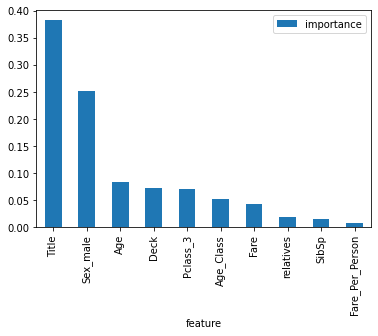

In [259]:
importances.plot.bar()



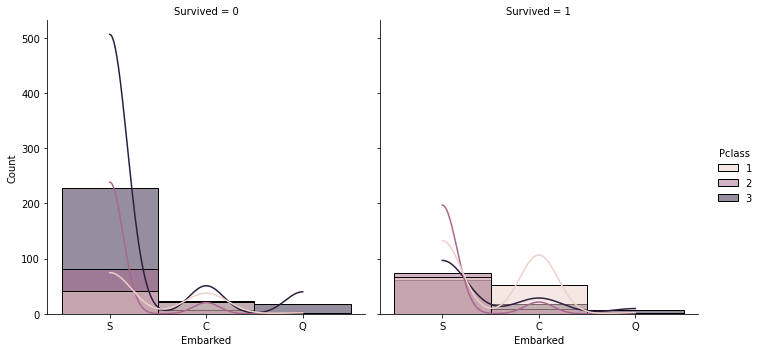

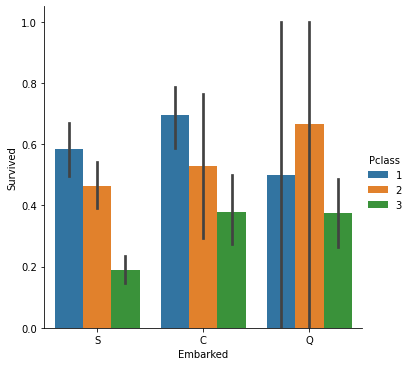

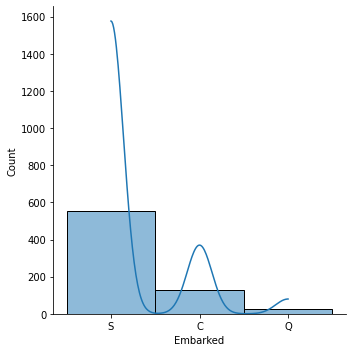

In [128]:

sns.displot(data=train_df.dropna(), x="Embarked", col="Survived",hue="Pclass", kde=True)
sns.catplot(data=train_df, kind="bar", x="Embarked", y="Survived", hue="Pclass")
sns.displot(data=train_df.dropna(), x="Embarked", kde=True)



24.0

In [156]:
train_df[train_df["Pclass"] == 1]["Age"].isnull().sum()
    
    

0